# Force Heat Map

In [1]:
import numpy as np
import array as arr
from mayavi import mlab
import matplotlib.pyplot as plt

def get_incl(x, y, z):
    # Gives inclination angle given cartesian coordinates x, y, z
    xyd = np.sqrt((x**2) + (y**2))
    return np.arctan2(xyd, z)                     

def get_az(x, y):
    # Gives azimuth angle given cartesian coordinates x, y 
    az = np.arctan2(y, x)
    az[az < 0] += 2*np.pi
    return az

def plot_axes(n, c=(0., 0., 0.)):    
    # n is number of axes wanted, c describes colour of axes
    o = np.zeros(2)
    a = np.array([0., n])
    mlab.plot3d(a, o, o, tube_radius=None, color=c)
    mlab.plot3d(o, a, o, tube_radius=None, color=c)
    mlab.plot3d(o, o, a, tube_radius=None, color=c)
    return

def polar_to_cart_elev(r, elev, az):
    # converts polar coordinates r, elev, az into cartesian coordinates x, y, z
    x = r * np.cos(elev) * np.cos(az)
    y = r * np.cos(elev) * np.sin(az)
    z = r * np.sin(elev)
    return x, y, z

## Extracting CASTEP info

In [2]:
forces = np.loadtxt('force_basis.csv', skiprows=1, dtype='float', delimiter=',', unpack=True)
forces = forces.T

Column index:
- 0 - cif number
- 1 - frac. coord x for hydrogen 1
- 2 - frac. coord y for hydrogen 1 
- 3 - frac. coord z for hydrogen 1
- 4 - frac. coord x for hydrogen 2
- 5 - frac. coord y for hydrogen 2
- 6 - frac. coord z for hydrogen 2
- 7 - force component x for hydrogen 1
- 8 - force component y for hydrogen 1
- 9 - force component z for hydrogen 1
- 10 - force component x for hydrogen 2
- 11 - force component y for hydrogen 2
- 12 - force component z for hydrogen 2

In [3]:
def total_force(f_x, f_y, f_z):
    t_f = np.sqrt(f_x**2 + f_y**2 + f_z**2)
    return t_f

In [4]:
t_f_1 = total_force(forces[:,7], forces[:,8], forces[:,9])
t_f_2 = total_force(forces[:,10], forces[:,11], forces[:,12])

In [5]:
# the hydrogen are currently centered around nitrogen at [0.5183, 0.2500, 0.2500]
# cell parameters are 8.34421466 9.00508907 10.46958114
# re-centering and converting hydrogen positions to cartesian coordinates from fractional coordinates:
h1_x = (forces[:,1] - 0.5183)*8.34421466
h1_y = (forces[:,2] - 0.2500)*9.00508907
h1_z = (forces[:,3] - 0.2500)*10.46958114

h2_x = (forces[:,4] - 0.5183)*8.34421466
h2_y = (forces[:,5] - 0.2500)*9.00508907
h2_z = (forces[:,6] - 0.2500)*10.46958114

## Creating Heatmaps

### Force Heatmap:

In [6]:
mlab.figure(bgcolor=(1., 1., 1.))
mlab.points3d(h1_x, h1_y, h1_z, t_f_1, colormap='viridis', scale_mode='none')
mlab.points3d(h2_x, h2_y, h2_z, t_f_2, colormap='viridis', scale_mode='none')
plot_axes(1.5)
mlab.orientation_axes()
#mlab.show()

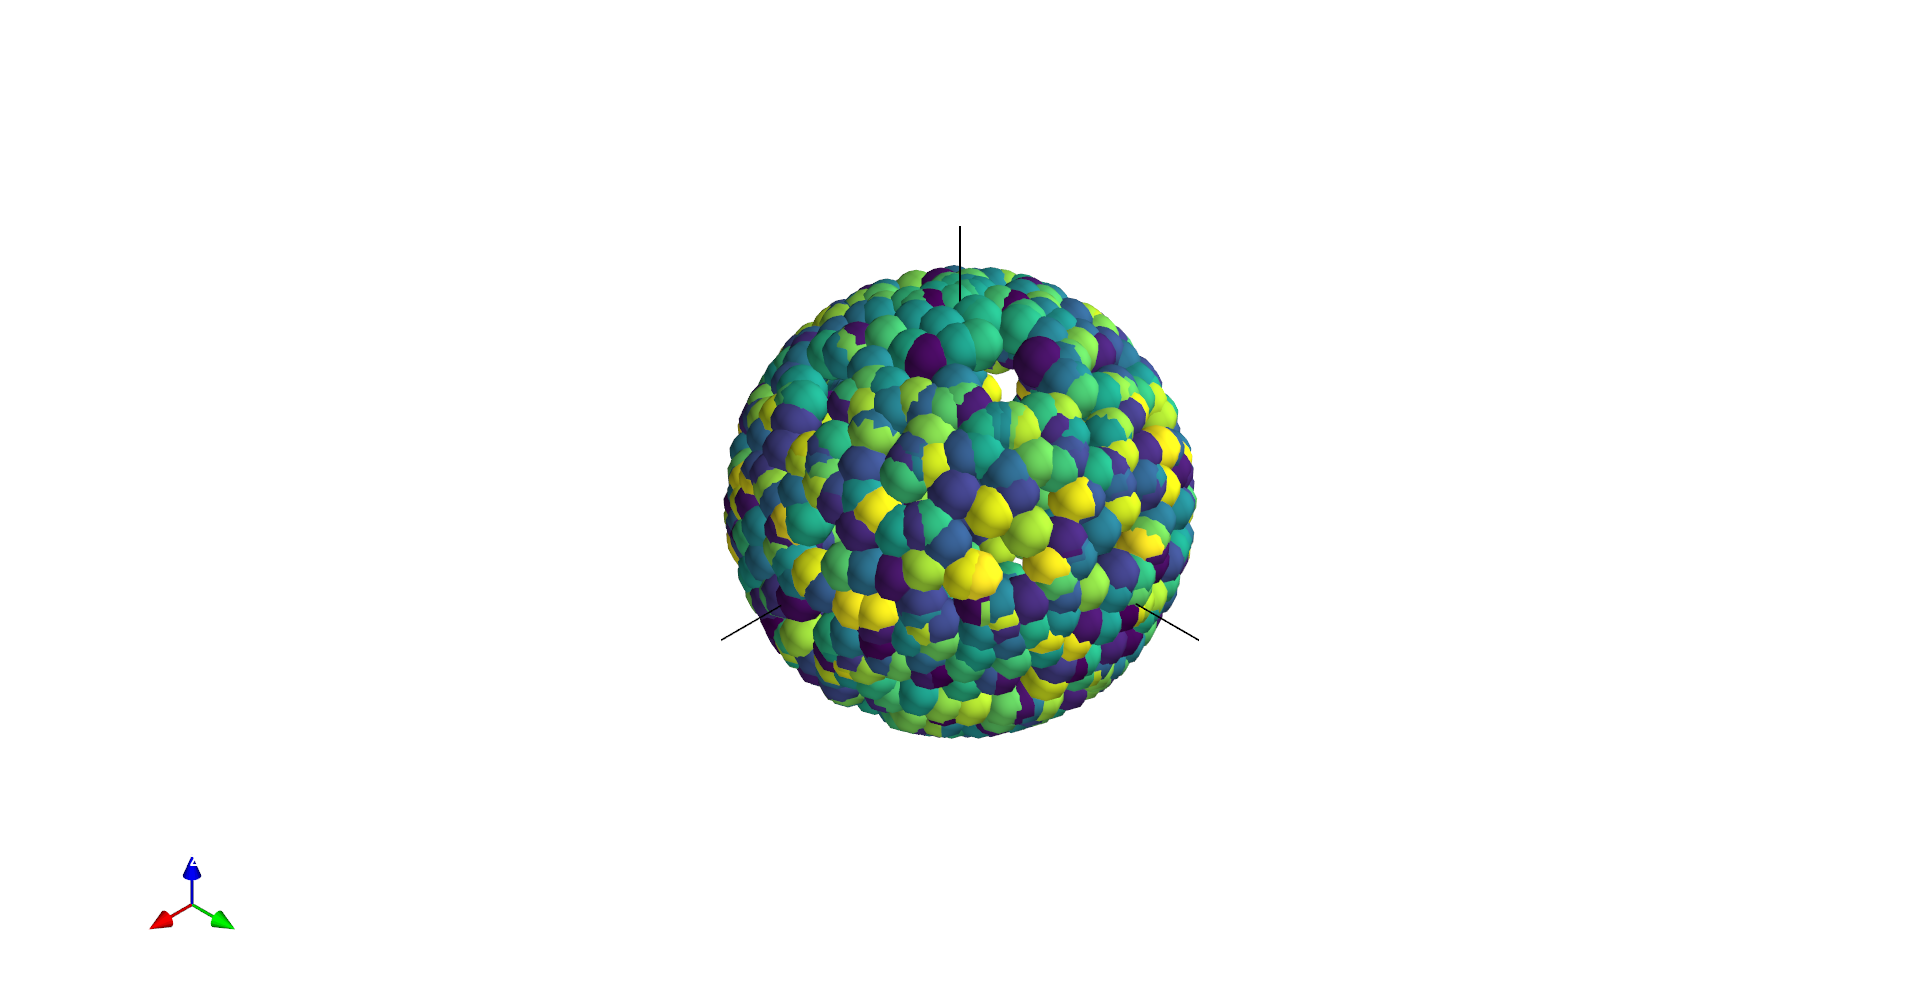

In [7]:
t_f = t_f_1 + t_f_2

min_index = np.argmin(t_f)
max_index = np.argmax(t_f)

print('Minimum energy cif: ' + str(int(forces[:,0][min_index])))
print('Maximum energy cif: ' + str(int(forces[:,0][max_index])))

Minimum energy cif: 1
Maximum energy cif: 700


Force Heatmap with Minimum Configuration Highlighted:

In [8]:
mlab.figure(bgcolor=(1., 1., 1.))
mlab.points3d(h1_x, h1_y, h1_z, t_f_1, colormap='viridis', scale_mode='none')
mlab.points3d(h2_x, h2_y, h2_z, t_f_2, colormap='viridis', scale_mode='none')
mlab.points3d(h1_x[min_index], h1_y[min_index], h1_z[min_index], scale_factor=0.25, color = (1., 0., 0.))
mlab.points3d(h2_x[min_index], h2_y[min_index], h2_z[min_index], scale_factor=0.25, color = (1., 0., 0.))
plot_axes(1.5)
mlab.orientation_axes()
#mlab.show()

Force Heatmap with Maximum Configuration Highlighted:

In [9]:
mlab.figure(bgcolor=(1., 1., 1.))
mlab.points3d(h1_x, h1_y, h1_z, t_f_1, colormap='viridis', scale_mode='none')
mlab.points3d(h2_x, h2_y, h2_z, t_f_2, colormap='viridis', scale_mode='none')
mlab.points3d(h1_x[max_index], h1_y[max_index], h1_z[max_index], scale_factor=0.25, color = (1., 0., 0.))
mlab.points3d(h2_x[max_index], h2_y[max_index], h2_z[max_index], scale_factor=0.25, color = (1., 0., 0.))
plot_axes(1.5)
mlab.orientation_axes()
#mlab.show()

Surface Heatmap Roughly Estimated:

In [10]:
x_t = np.concatenate((h1_x, h2_x))
y_t = np.concatenate((h1_y, h2_y))
z_t = np.concatenate((h1_z, h2_z))
f_t = np.concatenate((t_f_1, t_f_2))

In [11]:
mlab.figure(bgcolor=(1., 1., 1.))
pts = mlab.points3d(x_t, y_t, z_t, f_t, colormap='viridis', scale_mode='none', scale_factor=0.0)
mesh = mlab.pipeline.delaunay3d(pts)
surf = mlab.pipeline.surface(mesh)
plot_axes(1.5)
mlab.orientation_axes()
#mlab.show()

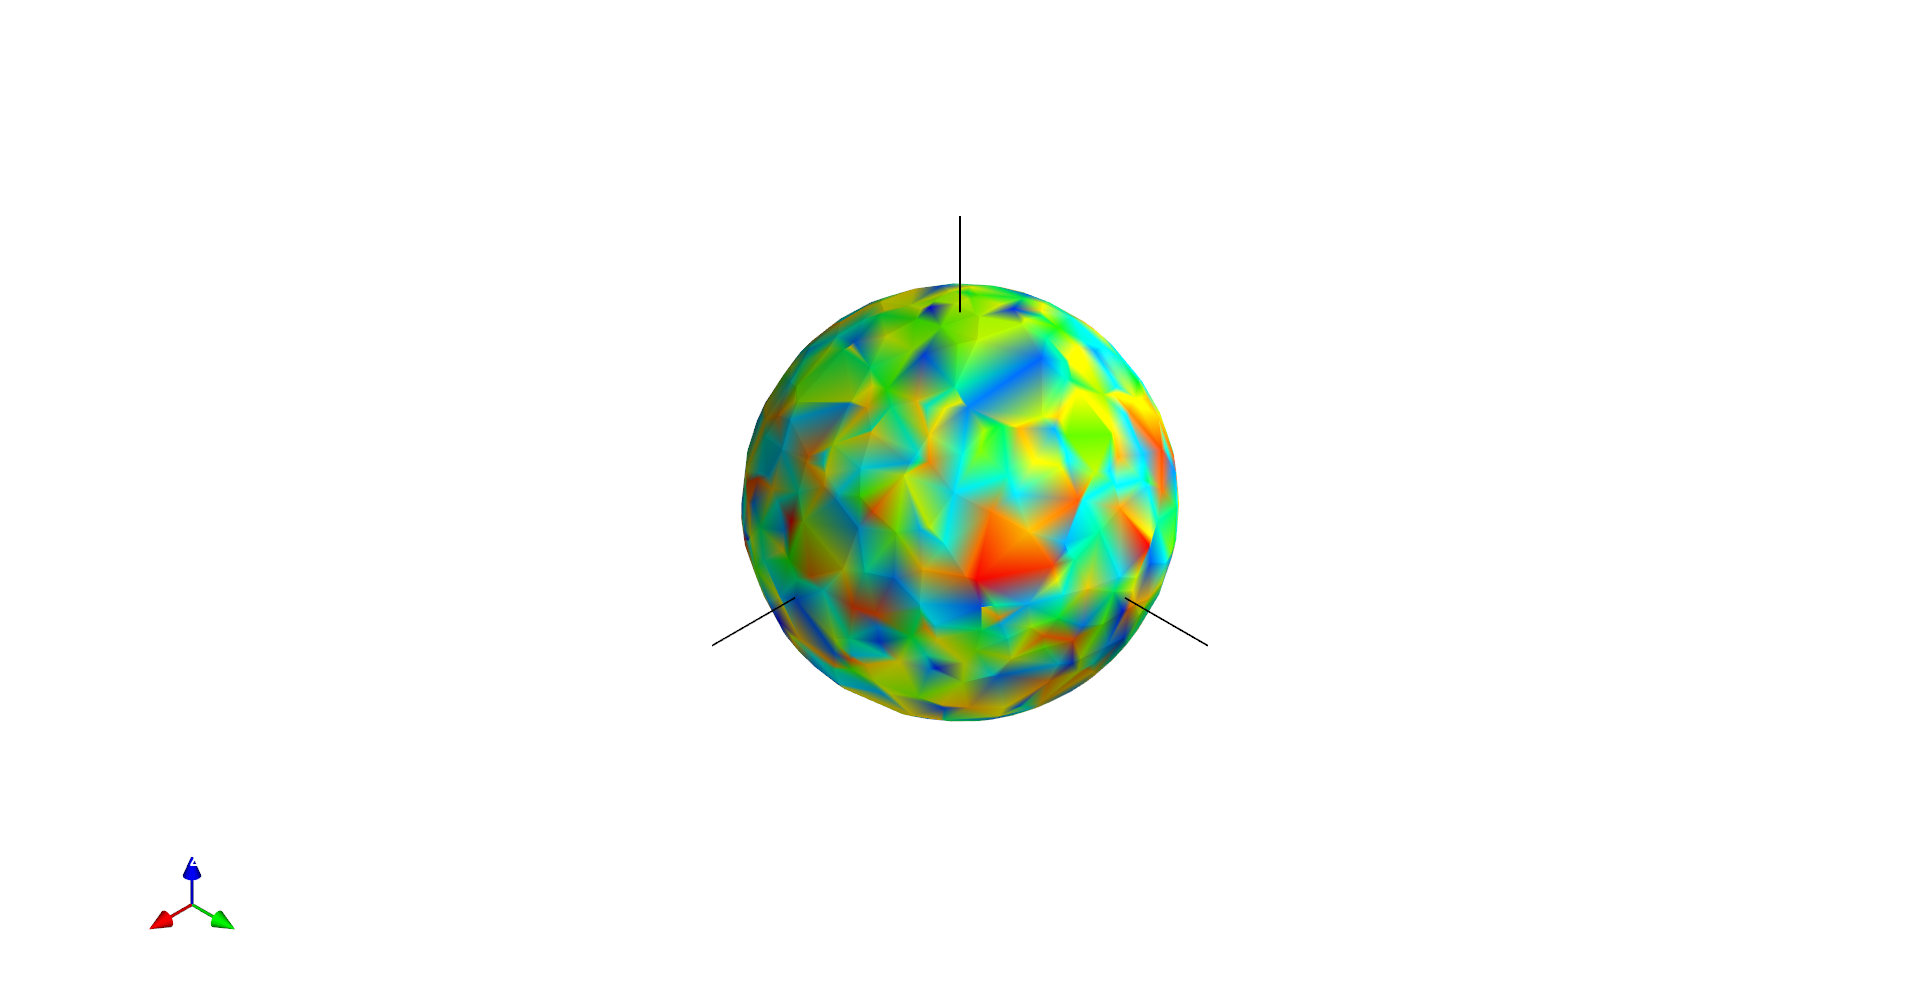

## Imputation

In [12]:
known_pts = np.column_stack((x_t, y_t, z_t))

In [13]:
from numpy import pi, cos, sin, arccos, arange

def spherical_grid(n=500):
    # n is the number of points created on the spherical grid
    indices = arange(0, n, dtype=float) + 0.5
    phi = arccos(1 - 2*indices/n)
    theta = pi * (1 + 5**0.5) * indices
    x, y, z = cos(theta) * sin(phi), sin(theta) * sin(phi), cos(phi)
    return x, y, z

grid = spherical_grid(n=10000)
grid_pts = np.column_stack((grid[0], grid[1], grid[2]))

In [14]:
def find_distances(known_pts, grid_pts):
    # returns distances between the known_pts and grid_pts
    # known_pts = cartesian coordinates of amide points
    # grid_pts = cartesian coordinates of generated points
    ds = np.zeros((known_pts.shape[0], grid_pts.shape[0]))
    for i, pt in enumerate(grid_pts):
        ds[:, i] = np.sqrt(((known_pts - pt)**2).sum(axis=1))
    return ds

In [15]:
ds = find_distances(known_pts, grid_pts)

In [16]:
def find_triangle(known_pts, grid_pts):
    # returns the three minimal distances between each point in known_pts and the grid_pts
    ds = find_distances(known_pts, grid_pts)
    #find minimum values sequentially - imide points are on a regular grid
    tds = np.zeros((grid_pts.shape[0], 3))
    min_args0 = ds.argmin(axis=0)
    tds[:, 0] = ds[(min_args0, np.arange(grid_pts.shape[0]))]
    ds[(min_args0, np.arange(grid_pts.shape[0]))] += 1
    min_args1 = ds.argmin(axis=0)
    tds[:, 1] = ds[(min_args1, np.arange(grid_pts.shape[0]))]
    ds[(min_args1, np.arange(grid_pts.shape[0]))] += 1
    min_args2 = ds.argmin(axis=0)
    tds[:, 2] = ds[(min_args2, np.arange(grid_pts.shape[0]))]
    td_args = np.column_stack((min_args0, min_args1, min_args2))
    # tds array of triangular distances
    # tds_args array of trinagular indices for known_pts
    return tds, td_args 

In [17]:
tds, td_args = find_triangle(known_pts, grid_pts)

In [18]:
def normalize_dists(tds):
    # normalises distances
    td_tot = tds.sum(axis=1)
    td_norm = tds / td_tot.reshape(len(td_tot), 1)
    tdn = 1 - td_norm
    tdn_tot = tdn.sum(axis=1)
    return tdn / tdn_tot.reshape(len(tdn_tot), 1)

In [19]:
tnds = normalize_dists(tds)
print(tnds.sum(axis=1))

[1. 1. 1. ... 1. 1. 1.]


In [20]:
def find_approx_forces(known_pts, grid_pts, f):
    # returns approximate force for a point in grid_pts
    # f - force of each amide point
    tds, td_args = find_triangle(known_pts, grid_pts)
    tnds = normalize_dists(tds)
    fc = (np.array([f[tda] for tda in td_args]) * tnds).sum(axis=1)
    return fc

In [21]:
fc = find_approx_forces(known_pts, grid_pts, f_t)

In [22]:
# visualises force potentials from imported data and translucent imputed force potential surface 
mlab.figure(bgcolor=(1., 1., 1.))
mlab.points3d(grid[0], grid[1], grid[2], fc, scale_factor=0.2, scale_mode='none', opacity=0.5, colormap='viridis')
mlab.points3d(x_t, y_t, z_t, f_t, scale_factor=0.1, scale_mode='none',colormap='viridis')
mlab.orientation_axes()
#mlab.show()

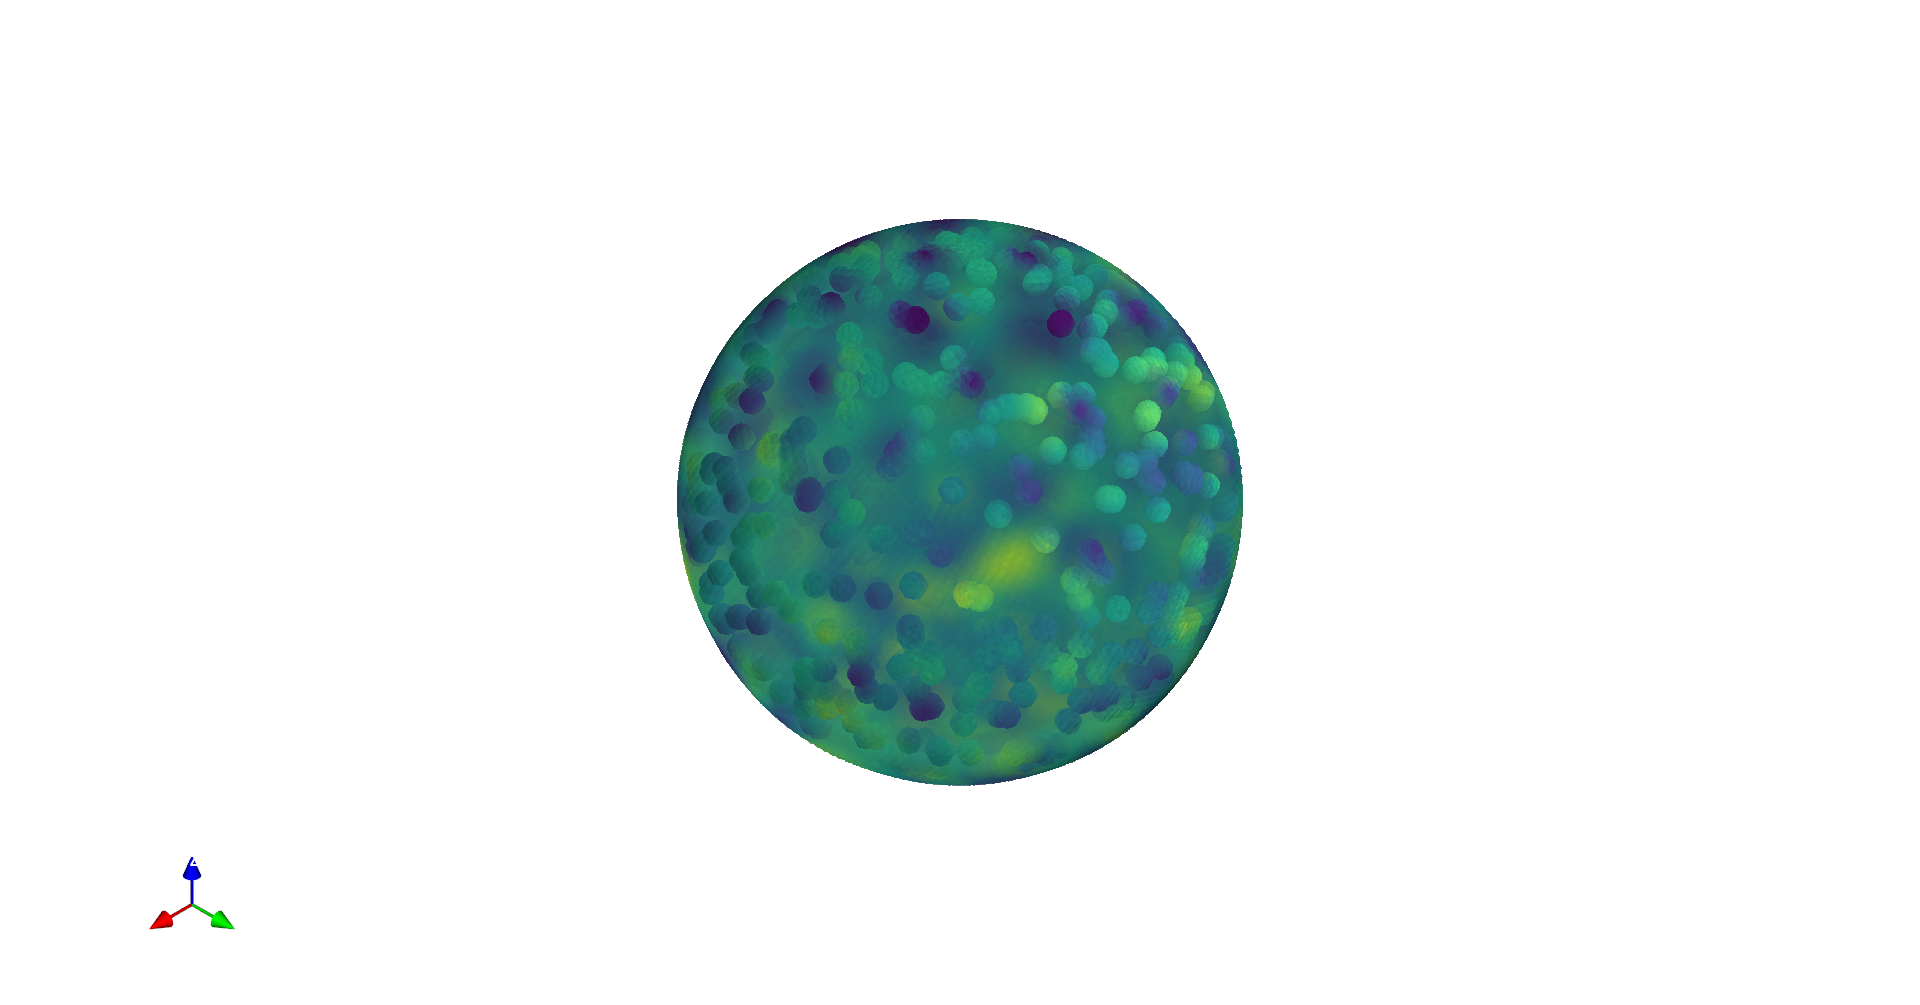

 ### Force Surface correctly imputed


In [23]:
mlab.figure(bgcolor=(1., 1., 1.))
mlab.points3d(grid[0], grid[1], grid[2], fc, scale_factor=0.2, scale_mode='none', colormap='viridis')
mlab.orientation_axes()
#mlab.show()

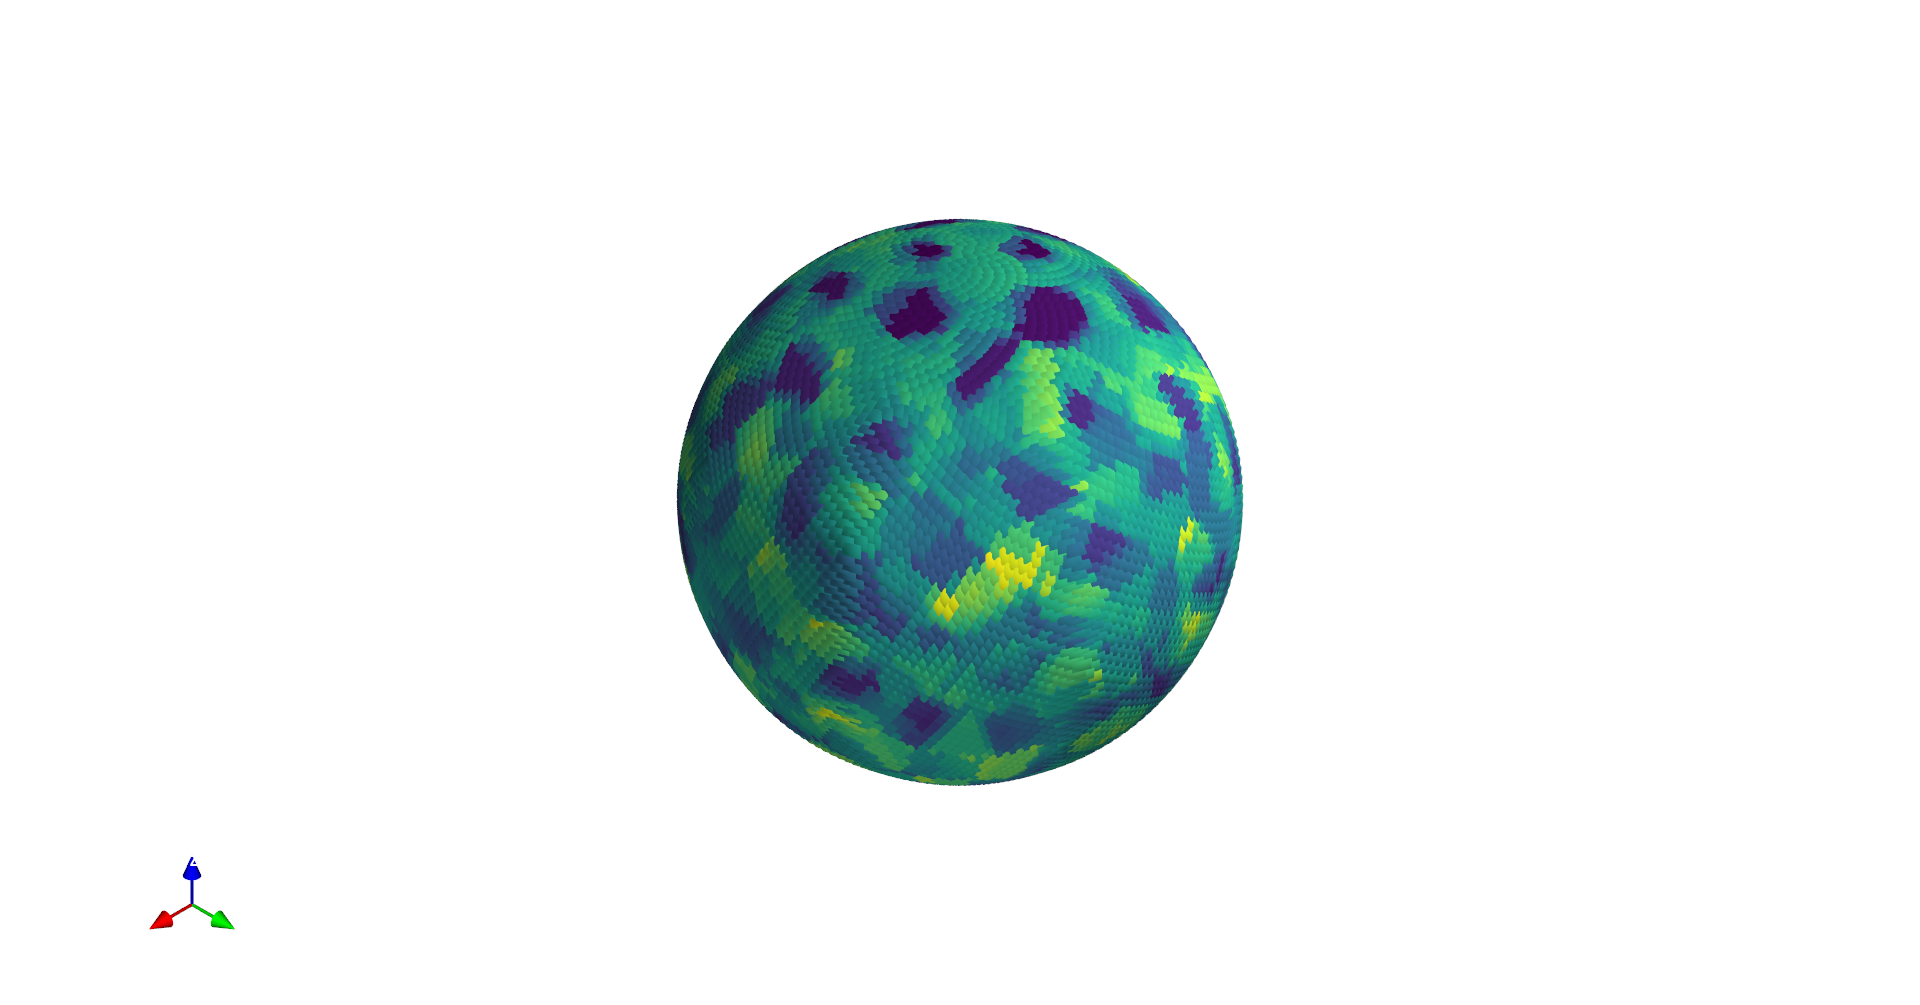

In [24]:
# exporting imputed force map data for use in Ammonia-Imide Cif Creation workbook
import pandas as pd
data = {'x': grid[0], 'y': grid[1], 'z': grid[2],
        'force': fc}
df = pd.DataFrame(data)
df.to_csv(r'C:\\Users\\tarab\\Downloads\\force_map_data_basis.csv', index=False)

- grid[0] - array 10,000 x positions on spherical grid
- grid[1] - array 10,000 y positions on spherical grid
- grid[2] - array 10,000 z positions on spherical grid
- fc - array 10,000 force values for each point on spherical grid imputed from known amide position values